<a href="https://colab.research.google.com/github/temiafeye/Colab-Projects/blob/master/Hybrid_Architecture_Network_using_GANS_and_Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
`# We are building an Hybrid Architecture Network, a combination of deep learning models, VAE+CPPN+GAN, to generate artistic images. 
The Hybrid Network consists of 

- VAE(variational autoencoder) = Q(encoder) + G(decoder)
- GAN (generative adversarial network) = G(generator) + D(discriminator)
- VAE - GAN = Q(encoder) + G(decoder/generator) + D(discriminator)



In [0]:
#Install Tensorflow 2.0 alpha
!pip install -q tensorflow-gpu==2.0.0-alpha0
# !pip install - q tensorboardcolab

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import IPython.display as display
import google.colab.files as files
import sys, time
import imageio, glob
print('Python version: ', sys.version) 
print('Tensorflow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name !='/device:GPU:0':
  raise SystemError('GPU Device not found')
print('GPU found at: {}'. format(device_name))

import tensorboardcolab as tbc
tb = tbc.TensorBoardColab()

Define Global Variables


In [0]:
NBATCH = 500 #size of the mini-batch
NX = 28 # image width 
NY = 28 #image height
NC = 1 #number of channels ()
NZ = 32 #VAE: size of latent variable
SCALE = 6 #CPPN: zooming scale 

In [0]:
#load the MNIST Dataset 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
x_train = x_train.reshape(-1, NY, NX, NC).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, NY, NX, NC).astype(np.float32) / 255.0
NSAMPLE = x_train.shape[0]
x_batches = tf.data.Dataset.from_tensor_slices(x_train).shuffle(NSAMPLE).batch(NBATCH)
print(x_train.shape, x_test.shape)

def find_x(digit):
  ''' find testing data by digit'''
  i = -1
  while i == -1 or y_test[i] != digit:
    i = np.random.randit(y_test.shape[0])
    return x_test[i:i+1]


(60000, 28, 28, 1) (10000, 28, 28, 1)


(500, 784, 3)


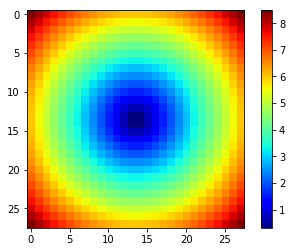

In [0]:
''' Pre-calculate CPPN coordinate matrices'''
def create_coordinates(nx=NX, ny=NY, scale=SCALE, nbatch=NBATCH):
  n = (nx+ny) / 2
  nx2, ny2 = nx/n*scale, ny/n*scale
  xs, ys = np.meshgrid(np.linspace(-nx2, nx2, nx), np.linspace(-ny2, ny2, ny))
  rs = np.sqrt(xs**2 + ys**2)
  
  xs_repeat = np.tile(np.reshape(xs, (1, nx*ny, 1)), (nbatch, 1, 1))
  ys_repeat = np.tile(np.reshape(xs, (1, nx*ny, 1)), (nbatch, 1, 1))
  rs_repeat = np.tile(np.reshape(xs, (1, nx*ny, 1)), (nbatch, 1, 1))
  coords = np.concatenate((xs_repeat, ys_repeat, rs_repeat), axis=-1).astype(np.float32)
  return coords, xs, ys, rs

coords, xs, ys, rs = create_coordinates()
plt.imshow(rs, cmap='jet')
plt.colorbar()

coords_sample, _, _, _ = create_coordinates(nbatch=5)

print(coords.shape)



Components - Define various compents of the hybrid structure

In [0]:
'''VAE (variational autoencoder) using MLP (multilayer perceptron)'''

def model_vae_encoder(name='VAE-Q', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NY, NX, NC)),
      layers.Flatten(),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(NZ + NZ),
  ], name=name)

def model_vae_decoder(name='VAE-P', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NZ,)),
      layers.Dense(nodes, activation = 'relu'),
      layers.Dense(nodes, activation = 'relu'),
      layers.Dense(NX*NY*NC, activation = 'sigmoid'),
      layers.Reshape([NY, NX, NC])
  ], name=name)

''' DCIGN (deep convolutional inverse graphics network)
= VAE using CNN (convolutional neural network)'''

def model_dcign_encoder(name='DCIGN-Q', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NY, NX, NC)),
      layers.Conv2D(nodes*1, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2D(nodes*2, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Flatten(),
      layers.Dense(NZ+NZ),
  ], name=name)

def model_dcign_decoder(name='DCIGN-P', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NZ,)),
      layers.Dense(7*7*nodes, activation='relu'),
      layers.Reshape((7, 7, nodes)),
      layers.Conv2DTranspose(nodes*2, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2DTranspose(nodes*1, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2DTranspose(NC, (3,3), strides=(1,1), padding='same', activation='relu'),
  ], name=name)

def param_splits(z_params):
  return tf.split(z_params, 2, axis=1)

def sample_func(z_params, mean=0, stddev=1):
  z_mean, z_logvar = param_split(z_params)
  eps = tf.random.normal(shape =tf.shape(z_mean), mean=mean, stddev=stddev)
  return z_mean + tf.exp(z_lagvar * 0.5) * eps

def sample(z_params, mean=0, stddev=1):
  return layers.Lambda(sample_func)(z_params)

''' CPPN(compositional pattern producing network)'''

def repeat_vector(inputs):
  vec_in, dim_in = inputs
  return layers.RepeatVector(K.shape(dim_in)[1]) (vec_in)

def model_cppn_generator(name='CPPN_G', levels=4, nodes=32, stddev=1):
  normal_init = tf.keras.initializers.RandomNormal (stddev = stddev)
  inits = {'kernel_initializer': normal_init} #this initializes the biases
  
  z_in = layers.Input(shape=(NZ,))
  coord_in = layers.Input(shape=(None, 3))
  h = layers.Lambda(repeat_vector, ouptut_shape=(None, NZ))([z_in, coord_in])
  h = layers.Concatenate() ([h, coord_in])
  h = layers.Dense(nodes, activation='softplus', **inits) (h)
  for i in range(levels):
    h = layers.Dense(nodes, activation='tanh', **inits) (h)
  h = layers.Dense(NC, activation='sigmoid', **inits) (h)
  x_out = layers.Flatten() (h)
  return tf.keras.Model(inputs=[z_in, coord_in], ouputs = x_out, name=name)

def sq(x, nx=NX, ny=NY, nc=NC):
  return tf.reshape(x, (-1, ny, nx, nc))


''' DCGAN(deep convolutional generative adversarial network) '''
def model_dcgan_generator(name='DCGAN-G', filters=32, stddev=0.02):
  inits = {}
  model = tf.keras.Sequential(name=name)
  model.add(layers.InputLayer(input_shape=(NZ,)))
  model.add(layers.Dense(7*7*filters*4, **inits))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7,7, filters*4)))
  for f, s in zip([2,1], [1,2]):
    model.add(layers.Conv2DTranspose(filters*f, (5,5), strides=(s,s), padding='same', **inits))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU)
  model.add(layers.Conv2DTranspose(NC, (5,5), strides=(2,2), padding='same', **inits, activation='tanh'))
  assert model.output_shape == (None, NY, NX,NC)
  return model

def model_dcgan_discriminator(name='DCGAN-D', filters=32, stddev=0.02):
  inits = {}
  
  model = tf.keras.Sequential(name=name)
  model.add(layers.InputLayer(input_shape=(NY, NX, NC)))
  for f in [1,2]:
    model.add(layers.Conv2D(filters*f, (5,5), strides=(2,2), padding='same', **inits))
    if f>1: model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, **inits)) 
    return model 
  
''' show graph of models'''

def display_models(models):
  imgs = []
  for m in models:
    tf.keras.utils.plot_models(m, to_file=m.name+'.png', show_shapes=True, show_layer=True)
    imgs.append(m.name)
    imgs.append(display.Image(retina=True, filename=m.name+'.png'))
    display.display(*imgs)
  



              


                    
                   

In [0]:
''' Define Loss function '''
def kid(z_mean, z_logvar):
  ''' Kullback-LEibler divergence in VAE'''
  return -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1) / (NX*NY*NC)

def bce(y1, y2):
  ''' Binary cross entropy for use in AE'''
  y1_flat = tf.reshape(y1, (-1, NX*NY*NC))
  y2_flat = tf.reshape(y1, (-1, NX*NY*NC))
  return tf.keras.losses.binary_crossentropy(y1_flat, y2_flat)

def bce_logits(b,y):
  ''' Binary cross-entropy from logits for use in GAN'''
  truth = tf.ones_like(y) if b else tf.zeros_like(y)
  return tf.keras.losses.binary_crossentropy(truth, y, from_logits=True)
  

Test

In [0]:
len(all_g_loss) /NSAMPLE*NBATCH

NameError: ignored

In [0]:
''' test CPPN '''
g = model_cppn_generator(levels=4, nodes=64, stddev=1)

XL = 20
coords_test = create_coordinates(nx=NX*XL, ny=NY*XL, scale=6, nbatch=1)

noise_z = tf.random.normal((1, NZ), stddev=1)
x3 = sq(g([noise_z, coords_test]), nx=NX*XL, ny=NY*XL)

plt.figure(figsize=(8,12))
plt.imshow(tf.reshape(x3[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
plt.axis('off')
plt.show()

TypeError: ignored